# Git Clone GPSat
this is need if running in colab

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# TODO: allow for mounting of gdrive
# TODO: allow for checking out a branch

if IN_COLAB:
    
    import os
    import re

    # change to working directory
    work_dir = "/content"
    
    assert os.path.exists(work_dir), f"workspace directory: {work_dir} does not exist"
    os.chdir(work_dir)
    
    # clone repository
    !git clone https://github.com/CPOMUCL/GPSat.git

    repo_dir = os.path.join(work_dir, "GPSat")

    print(f"changing directory to: {repo_dir}")
    os.chdir(repo_dir)


## install the requirements

In [2]:
if IN_COLAB:
    !pip install -r requirements.txt

## install the GPSat pacakge in editable mode

In [3]:
if IN_COLAB:
    !pip install -e .


# import packages


In [4]:
# simple inline example of OI
# NOTE: there is no smoothing of hyper parameters

import os
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# provides a land/ocean mask
from global_land_mask import globe

# to prevent printing of log INFO to screen - needs to be set before tf / gpflow import
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.utils import WGS84toEASE2_New, EASE2toWGS84_New, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.postprocessing import smooth_hyperparameters
from GPSat.plot_utils import plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data, plot_hyper_parameters


2024-02-07 10:55:21.099038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 10:55:21.099080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 10:55:21.100141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 10:55:21.862506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# read in raw data


In [5]:

# read in all the *_RAW.csv files in data/example
# - get files to read
raw_files = [get_data_path("example", i)
             for i in os.listdir(get_data_path("example")) if re.search("_RAW\.csv$", i)]

# read in, add source col
tmp = []
for rw in raw_files:
    source = re.sub("_RAW\.csv$", "", os.path.basename(rw))
    _ = pd.read_csv(rw)
    _['source'] = source
    tmp.append(_)
df = pd.concat(tmp)


# convert lon, lat, datetime to x, y, t - to be used as the coordinate space
# - x,y are in meters, t in days
df['x'], df['y'] = WGS84toEASE2_New(lon=df['lon'], lat=df['lat'], lat_0=90, lon_0=0)
df['t'] = df['datetime'].values.astype("datetime64[D]").astype(float)



# Pre-process (bin) raw data


In [6]:
# bin by date, source to a 50x50km grid
# - returns a DataSet
bin_ds = DataPrep.bin_data_by(df=df.loc[(df['z'] > -0.35) & (df['z'] < 0.65)],
                              by_cols=['t', 'source'],
                              val_col='z',
                              x_col='x',
                              y_col='y',
                              grid_res=50_000,
                              x_range=[-4500000.0, 4500000.0],
                              y_range=[-4500000.0, 4500000.0])

# convert bin data to DataFrame
# - removing all the nans that would be added at grid locations away from data
bin_df = bin_ds.to_dataframe().dropna().reset_index()


'bin_data_by': 1.880 seconds



# plot binned data

'plot_pcolormesh': 0.045 seconds


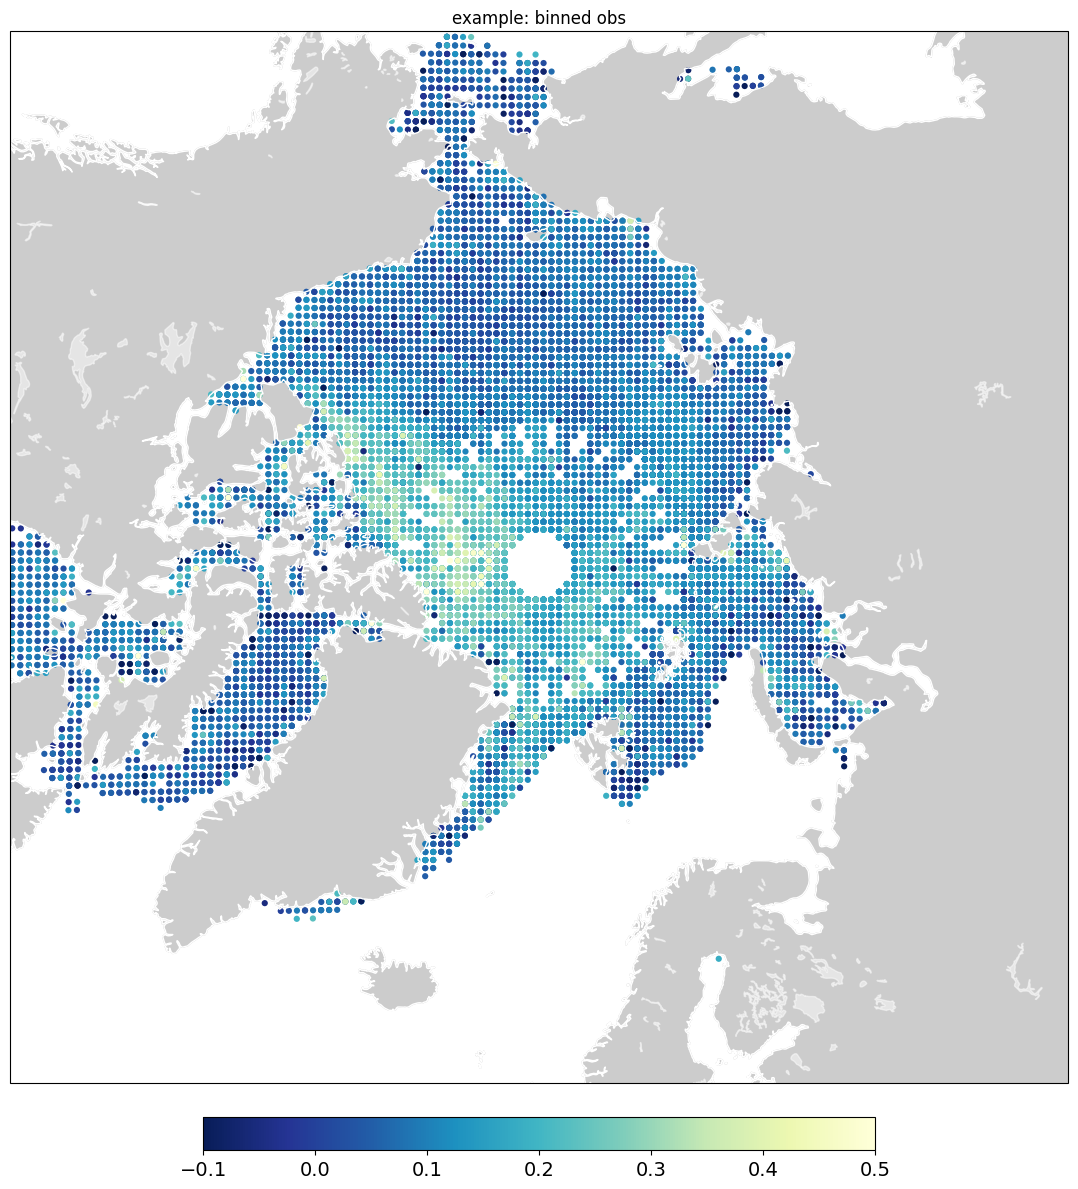

In [7]:
# this will plot all observations, some on top of each other
bin_df['lon'], bin_df['lat'] = EASE2toWGS84_New(bin_df['x'], bin_df['y'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))
# plot value range
vmin, vmax = -0.1, 0.5

plot_pcolormesh(ax=ax,
                lon=bin_df['lon'],
                lat=bin_df['lat'],
                plot_data=bin_df['z'],
                title="example: binned obs",
                scatter=True,
                vmin=vmin, 
                vmax=vmax,
                s=20,
                fig=fig,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()

# expert locations - on evenly spaced grid


In [8]:
# - spaced every 200km for some x,y range
expert_x_range = [-750000.0, 1000000.0]
expert_y_range = [-500000.0, 1250000.0]
xy_grid = grid_2d_flatten(x_range=expert_x_range,
                          y_range=expert_y_range,
                          step_size=200_000)

# store in dataframe
eloc = pd.DataFrame(xy_grid, columns=['x', 'y'])

# add a time coordinate
eloc['t'] = np.floor(df['t'].mean())


# plot expert locations


'plot_pcolormesh': 0.008 seconds


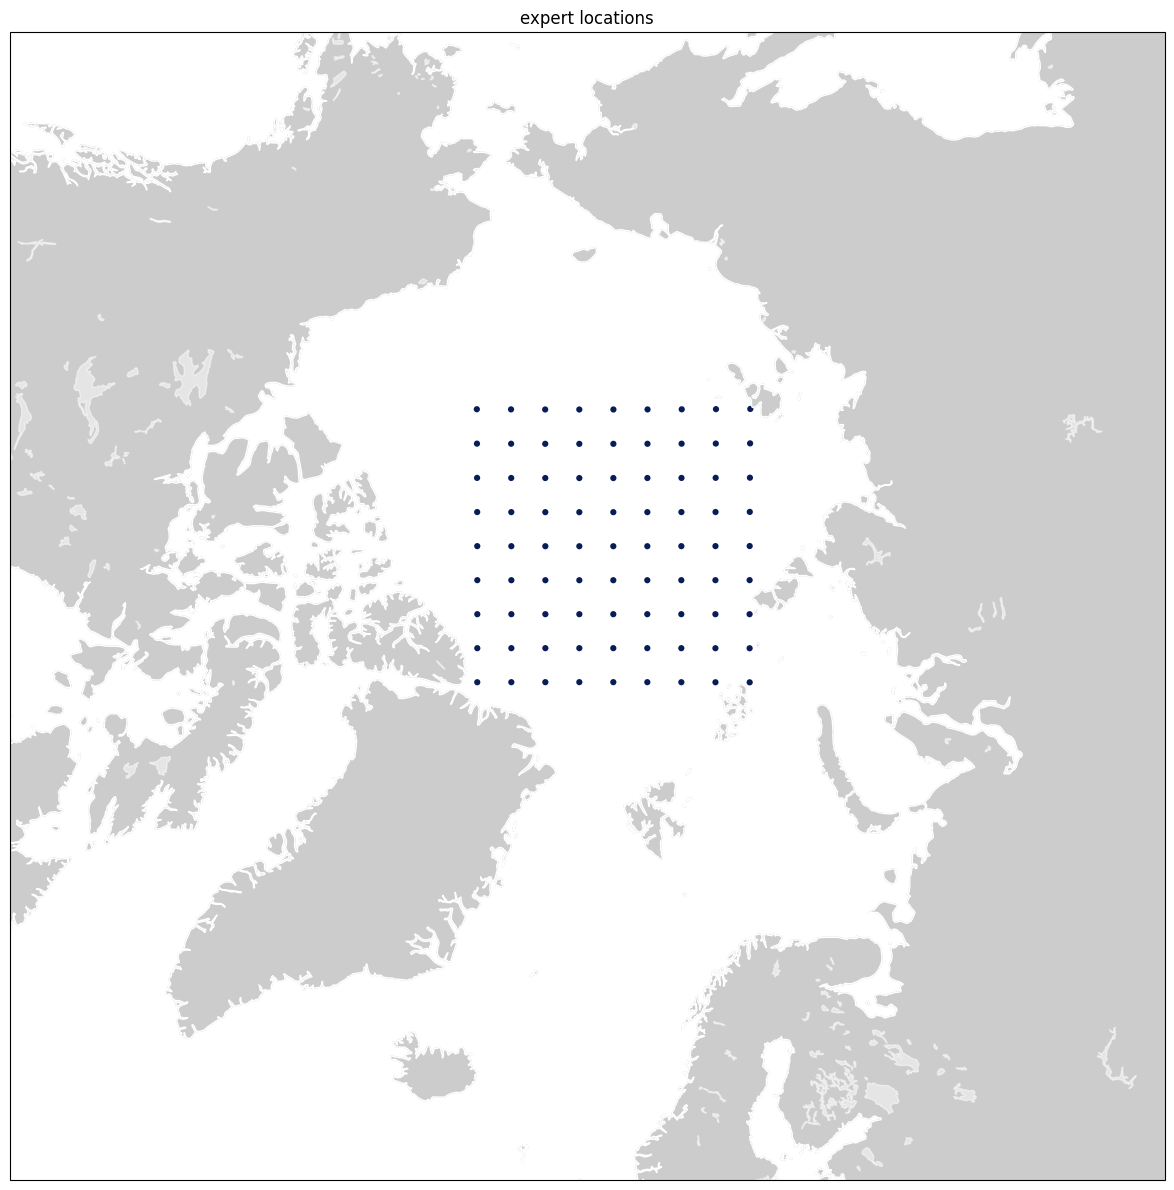

In [9]:

eloc['lon'], eloc['lat'] = EASE2toWGS84_New(eloc['x'], eloc['y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=eloc['lon'],
                lat=eloc['lat'],
                plot_data=eloc['t'],
                title="expert locations",
                scatter=True,
                s=20,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()


# prediction locations


In [10]:

# - spaced every 5km
pred_xy_grid = grid_2d_flatten(x_range=expert_x_range,
                               y_range=expert_y_range,
                               step_size=5_000)

# store in dataframe
# NOTE: the missing 't' coordinate will be determine by the expert location
# - alternatively the prediction location can be specified
ploc = pd.DataFrame(pred_xy_grid, columns=['x', 'y'])

# add lon,lat 
ploc['lon'], ploc['lat'] = EASE2toWGS84_New(ploc['x'], ploc['y'])

# identify if a position is in the ocean (water) or not
ploc["is_in_ocean"] = globe.is_ocean(ploc['lat'], ploc['lon'])

# keep only prediction locations in ocean
ploc = ploc.loc[ploc["is_in_ocean"]]


# plot prediction locations


'plot_pcolormesh': 0.028 seconds


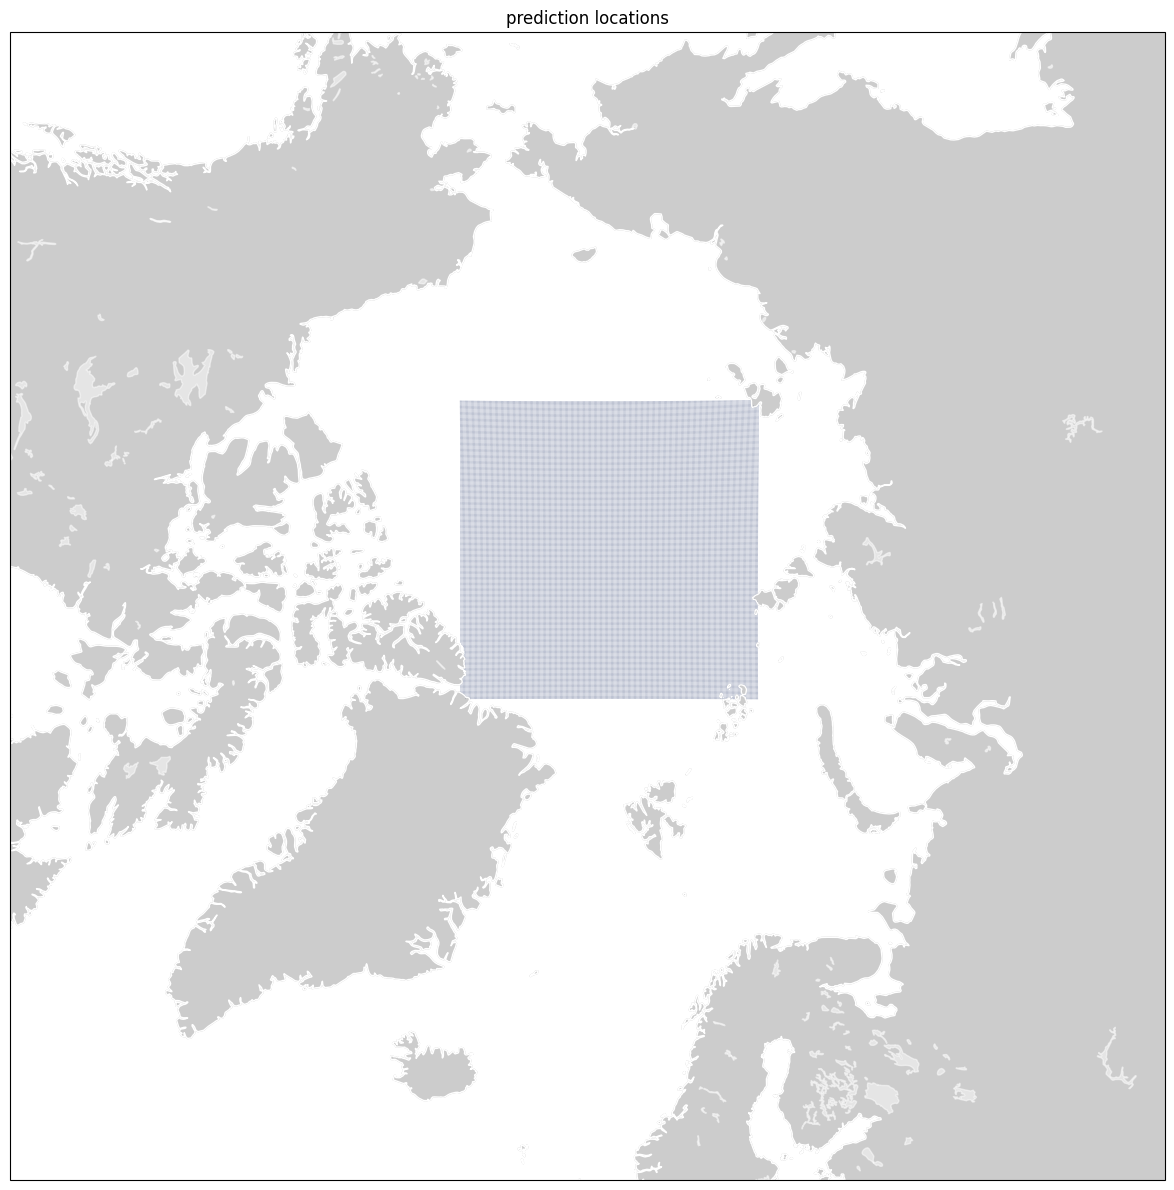

In [11]:
ploc['lon'], ploc['lat'] = EASE2toWGS84_New(ploc['x'], ploc['y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=ploc['lon'],
                lat=ploc['lat'],
                plot_data=np.full(len(ploc), 1.0), #np.arange(len(ploc)),
                title="prediction locations",
                scatter=True,
                s=0.1,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()



# configurations for Local Expert OI


In [12]:


# observation data
data = {
    "data_source": bin_df,
    "obs_col": "z",
    "coords_col": ["x", "y", "t"],
    # selection criteria used for each local expert
    "local_select": [
        {
            "col": "t",
            "comp": "<=",
            "val": 4
        },
        {
            "col": "t",
            "comp": ">=",
            "val": -4
        },
        {
            "col": [
                "x",
                "y"
            ],
            "comp": "<",
            "val": 300_000
        }
    ]
}

# local expert locations
local_expert = {
    "source": eloc
}

# model
model = {
    "oi_model": "GPflowGPRModel",
    "init_params": {
        # scale (divide) coordinates
        "coords_scale": [50000, 50000, 1]
    },
    "constraints": {
        # lengthscales - same order coord_col (see data)
        "lengthscales": {
            "low": [1e-08, 1e-08, 1e-08],
            "high": [600000, 600000, 9]
        }
    }
}

# prediction locations
# -
pred_loc = {
    "method": "from_dataframe",
    "df": ploc,
    "max_dist": 200_000
}


# Local Expert OI

NOTE: in Colab if this falls over due to Tensorflow error try: Runtime -> 'Restart session and run all'


In [13]:
locexp = LocalExpertOI(expert_loc_config=local_expert,
                       data_config=data,
                       model_config=model,
                       pred_loc_config=pred_loc)



'data_select': 0.000 seconds
'load': 0.001 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 22522 >  100
storing as str
in json_serializable - key: 'df' has value DataFrame/Series, but is too long: 122024 >  100
storing as str


# run optimal interpolation

In [14]:
# path to store results
store_path = get_parent_path("results", "inline_example.h5")

# for the purposes of a simple example, if store_path exists: delete it
if os.path.exists(store_path):
    cprint(f"removing: {store_path}")
    os.remove(store_path)

# run optimal interpolation
locexp.run(store_path=store_path,
           optimise=True)

removing: /home/buddy/workspace/pyOI/PyOptimalInterpolation/results/inline_example.h5
---------
storing expert locations in 'expert_locs' table
exception occurred: 'No object named expert_locs in the file'
will now close object

---------
dropping expert locations that already exists in 'run_details' table
exception occurred: 'No object named run_details in the file'
will now close object

--------------------------------------------------
1 / 81
current local expert:
          x         y        t        lon       lat
0 -650000.0 -400000.0  18326.0 -58.392498  83.16251
'data_select': 0.001 seconds
'load': 0.001 seconds
'local_data_select': 0.006 seconds
number obs: 185
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 1.659 seconds
'get_parameters': 0.006 seconds
'set_lengthscales_constraints': 0.008 seconds
**********
optimization failed!
'optimise_parameters': 2.917 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 8.505014  , 11.99994671,  1.76969386

# Smooth Hyper Parameters (Optional)

Each expert location's hyper parameters are calculated independently. They can be smoothed with a Gaussian kernel to avoid large jumps, which may affect predictions.

In [15]:
smooth_config = {
    # get hyper parameters from the previously stored results
    "result_file": store_path,
    # store the smoothed hyper parameters in the same file
    "output_file": store_path,
    # get the hyper params from tables ending with this suffix ("" is default):
    "reference_table_suffix": "",
    # newly smoothed hyper parameters will be store in tables ending with table_suffix
    "table_suffix": "_SMOOTHED",
    # dimension names to smooth over
    "xy_dims": [
        "x",
        "y"
    ],
    # parameters to smooth
    "params_to_smooth": [
        "lengthscales",
        "kernel_variance",
        "likelihood_variance"
    ],
    # length scales for the kernel smoother in each dimension
    # - as well as any min/max values to apply
    "smooth_config_dict": {
        "lengthscales": {
            "l_x": 200_000,
            "l_y": 200_000
        },
        "likelihood_variance": {
            "l_x": 200_000,
            "l_y": 200_000,
            "max": 0.3
        },
        "kernel_variance": {
            "l_x": 200_000,
            "l_y": 200_000,
            "max": 0.1
        }
    },
    "save_config_file": True
}

In [16]:
# if save_config_file = True then smooth_hyperparameters will save a config that can be used for generating predictions using smoother hyper parameters
smooth_result_config_file = smooth_hyperparameters(**smooth_config)

found model_name: GPflowGPRModel
found GPU
setting lengthscales to: [1.]
'__init__': 0.034 seconds
reading in results
selecting only tables: ['lengthscales', 'kernel_variance', 'likelihood_variance']
'data_select': 0.001 seconds
'load': 0.001 seconds
expert_locations data will not be merged on results data
adding smoothed table: lengthscales_SMOOTHED
adding smoothed table: kernel_variance_SMOOTHED
adding smoothed table: likelihood_variance_SMOOTHED
writing (smoothed) hyper parameters to:
/home/buddy/workspace/pyOI/PyOptimalInterpolation/results/inline_example.h5
table_suffix:_SMOOTHED
writing: lengthscales_SMOOTHED to table
writing: kernel_variance_SMOOTHED to table
writing: likelihood_variance_SMOOTHED to table
writing config (to use to make predictions with smoothed values) to:
/home/buddy/workspace/pyOI/PyOptimalInterpolation/results/inline_example_SMOOTHED.json


In [17]:
# modify the model configuration to include "load_params"
model_load_params = model.copy()
model_load_params["load_params"] = {
                "file": store_path,
                "table_suffix": smooth_config["table_suffix"]
            }

In [18]:
locexp_smooth = LocalExpertOI(expert_loc_config=local_expert,
                       data_config=data,
                       model_config=model_load_params,
                       pred_loc_config=pred_loc)


# run optimal interpolation (again)
# - this time don't optimise hyper parameters, but make predictions
# - store results in new tables ending with '_SMOOTHED'
locexp_smooth.run(store_path=store_path,
                  optimise=False,
                  predict=True,
                  table_suffix=smooth_config['table_suffix'],
                  check_config_compatible=False)

'data_select': 0.001 seconds
'load': 0.001 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 22522 >  100
storing as str
in json_serializable - key: 'df' has value DataFrame/Series, but is too long: 122024 >  100
storing as str
---------
storing expert locations in 'expert_locs' table
exception occurred: 'No object named expert_locs_SMOOTHED in the file'
will now close object

---------
dropping expert locations that already exists in 'run_details' table
exception occurred: 'No object named run_details_SMOOTHED in the file'
will now close object

--------------------------------------------------
1 / 81
current local expert:
          x         y        t        lon       lat
0 -650000.0 -400000.0  18326.0 -58.392498  83.16251
'data_select': 0.000 seconds
'load': 0.001 seconds
'local_data_select': 0.006 seconds
number obs: 185
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.026 seconds
'get_parameters': 0.006 seconds
'_read_param


# results (predictions and parameters) are store in hdf5


In [19]:

# extract, store in dict
dfs, oi_config = get_results_from_h5file(store_path, table_suffix=smooth_config['table_suffix'])

print(f"tables in results file: {list(dfs.keys())}")


reading in results
getting all tables
merging on expert location data
table: 'oi_config' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
table: 'oi_config_SMOOTHED' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
tables in results file: ['expert_locs', 'expert_locs_SMOOTHED', 'kernel_variance', 'kernel_variance_SMOOTHED', 'lengthscales', 'lengthscales_SMOOTHED', 'likelihood_variance', 'likelihood_variance_SMOOTHED', 'oi_config', 'oi_config_SMOOTHED', 'preds', 'preds_SMOOTHED', 'run_details', 'run_details_SMOOTHED']


# Plot Smoothed Hyper Parameters

'data_select': 0.001 seconds
'load': 0.002 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.020 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.017 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.018 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.018 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.018 seconds


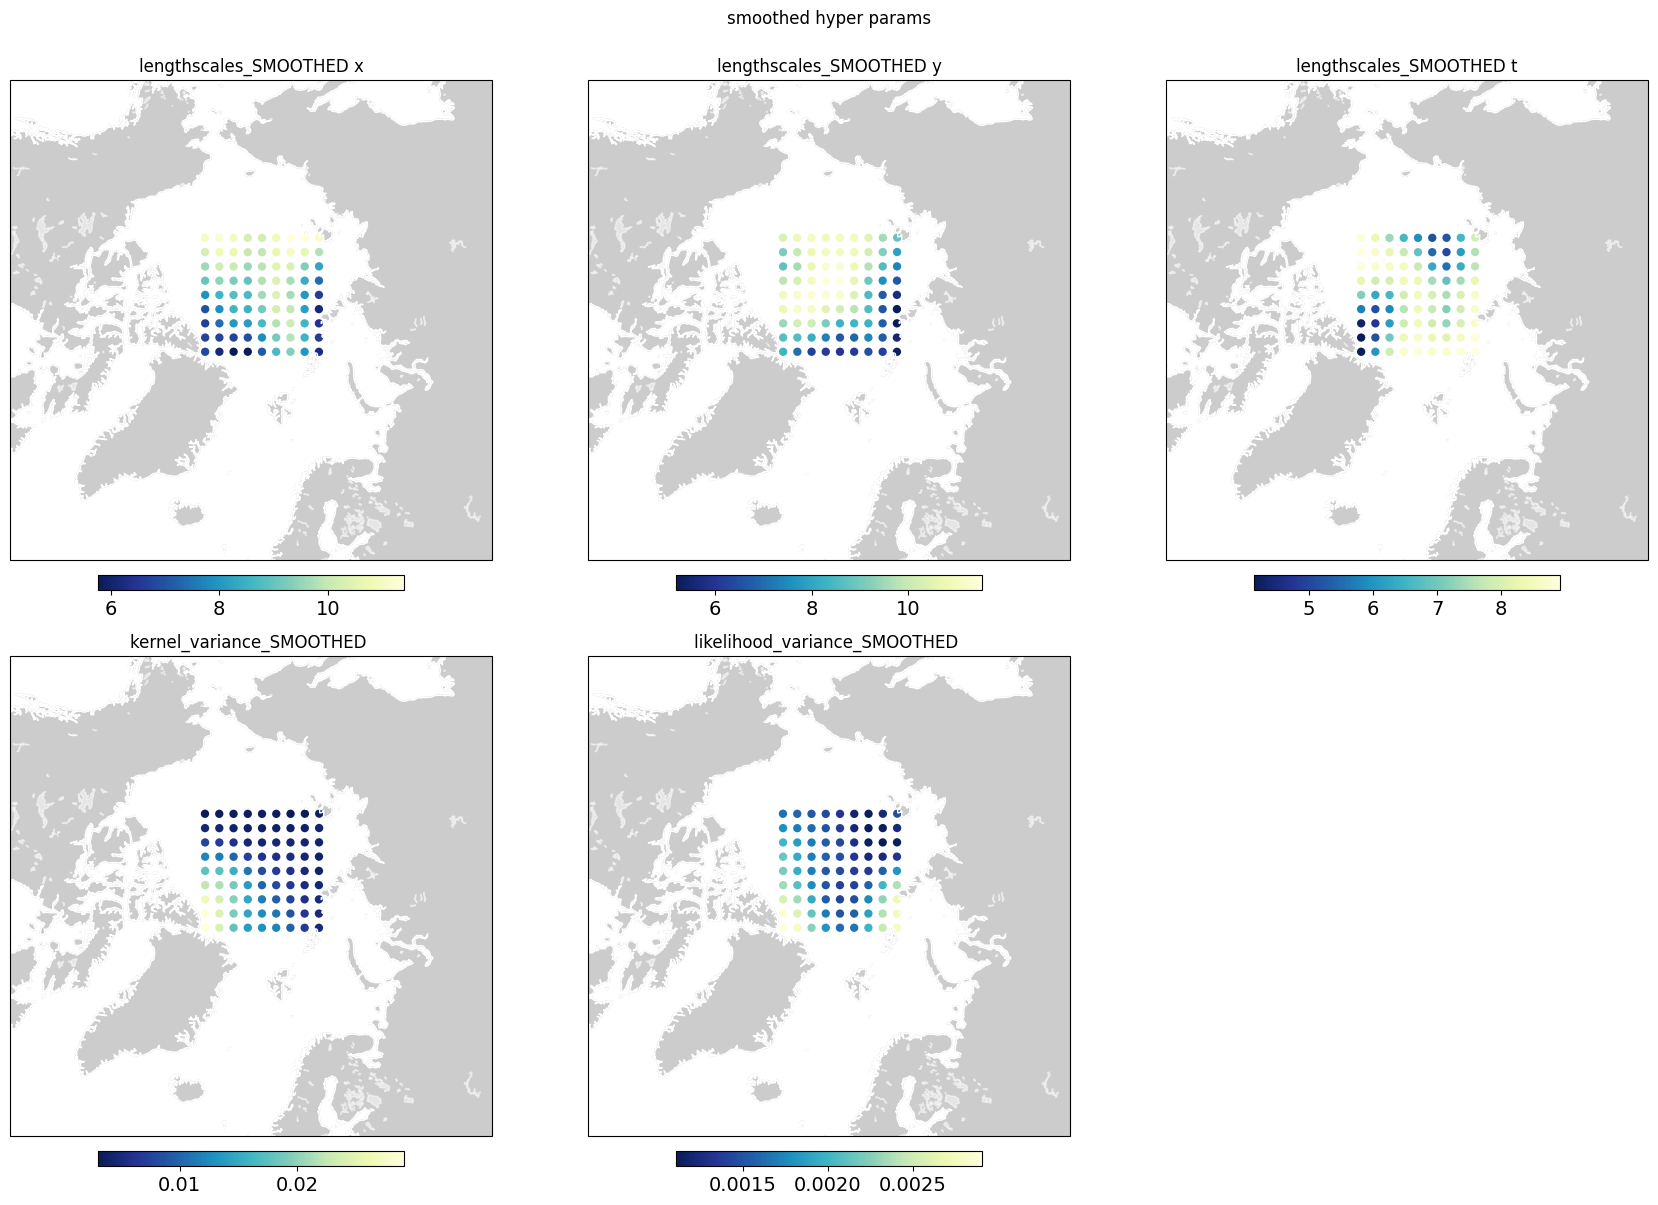

In [20]:

plot_template = {
    "plot_type": "heatmap",
    "x_col": "x",
    "y_col": "y",
    # use a northern hemisphere projection, centered at (lat,lon) = (90,0)
    "subplot_kwargs": {"projection": "north"},
    "lat_0": 90,
    "lon_0": 0,
    # any additional arguments for plot_hist
    "plot_kwargs": {
        "scatter": True,
    },
    # lat/lon_col needed if scatter = True
    # TODO: remove the need for this
    "lat_col": "lat",
    "lon_col": "lon",
}

fig = plot_hyper_parameters(dfs,
                            coords_col=oi_config[0]['data']['coords_col'], # ['x', 'y', 't']
                            row_select=None,
                            table_names=["lengthscales", "kernel_variance", "likelihood_variance"],
                            table_suffix=smooth_config["table_suffix"],
                            plot_template=plot_template,
                            plots_per_row=3,
                            suptitle="smoothed hyper params",
                            qvmin=0.01,
                            qvmax=0.99)

plt.tight_layout()
plt.show()


# plot the (weighted) predictions


'data_select': 0.002 seconds
'load': 0.005 seconds
'plot_pcolormesh': 0.071 seconds


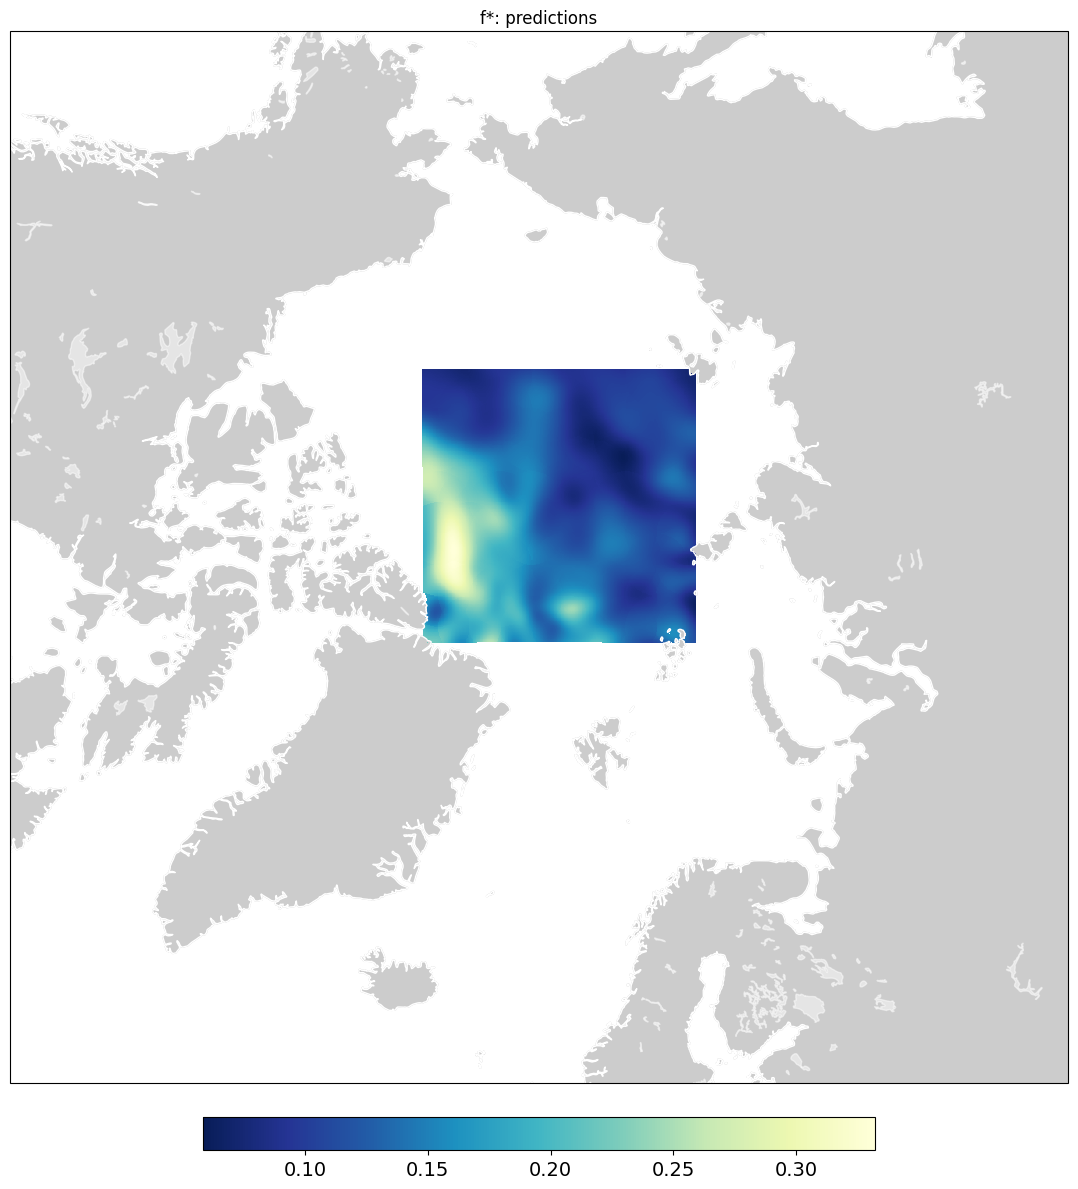

In [21]:
# plt_data = dfs["preds"]
plt_data = dfs["preds" + smooth_config['table_suffix']]

# multiple local experts may make predictions at the same prediction location (pred_loc).
# - for each prediction at a given location, take we weighted combination
# - weights being a function of the distance to each local expert that made a prediction at a given location.
weighted_values_kwargs = {
        "ref_col": ["pred_loc_x", "pred_loc_y", "pred_loc_t"],
        "dist_to_col": ["x", "y", "t"],
        "val_cols": ["f*", "f*_var"],
        "weight_function": "gaussian",
        "lengthscale": 200_000
    }
plt_data = get_weighted_values(df=plt_data, **weighted_values_kwargs)

# add convert x,y to lon,lat
plt_data['lon'], plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'], plt_data['pred_loc_y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))
plot_pcolormesh_from_results_data(ax=ax,
                                  dfs={"preds": plt_data},
                                  table='preds',
                                  val_col="f*",
                                  scatter=False,
                                  x_col='pred_loc_x',
                                  y_col='pred_loc_y',
                                  fig=fig,
                                  plot_kwargs={"title": "f*: predictions"},
                                  vmin=vmin,
                                  vmax=vmax)
plt.tight_layout()
plt.show()





